# CMPINF 0010 Final Project
---
In this final project, our team has been tasked to find the best neighborhood in Pittsburgh through our own metrics.

DESCRIBE WHY WE CHOSE SAID METRICS

## Metric 1 - Arrest/Crime Data
---
One of the first metrics that our group thought of was safety, no matter what the benefits of a neighborhood are, if there is a high crime rate. In order to get measurable metric, we needed to import the Pittsburgh arrests CSV file and count the number of times a crime was committed in certian neighborhood in order to calculate crime rates for each neighborhood.

The first step is displayed below:

In [39]:
import pandas as pd
import geopandas
import matplotlib
import matplotlib.pyplot as plt 
%matplotlib inline
# the matplotlib inline allows you to display all graphs in Jupyter Notebooks
# the matplotlib.pyplot import allows you to manipulate plot, can use interface to generate plot

<AxesSubplot:>

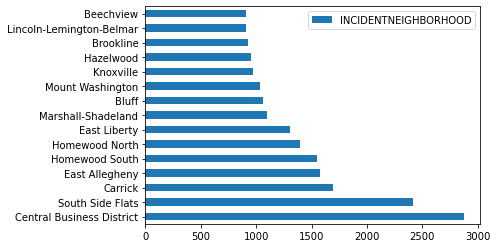

In [40]:
# create the initial read in file
arrestFile = pd.read_csv("CSVs/Arrests.csv")

# create a new DataFrame that counts the number of occurances of arrests by neighborhood
arrestsPerHood = pd.DataFrame(arrestFile["INCIDENTNEIGHBORHOOD"].value_counts(ascending = False))

# displays the data
arrestsPerHood.head(15).plot.barh()

After counting my data, we needed to import data from a separate CSV on population data for the neighborhoods in Pittsburgh so that we can merge the DataFrames and then calculate the crime rate.

In the population data, we encountered some varying ways of dsiplaying neighborhood names such as "Mount Oliver" and "Mount Oliver Borough." we first went through the data and changed the names to match each other so that the DataFrames would contain both the proper arrests and population data. We did run into the name "Mt. Oliver Neighborhood", which was not as explicit about which neighborhood it was. We decided to categorize this into Mount Oliver as the "neighborhood" section of the name delineated this category from the borough.

The next steps are displayed in the following cell:

In [41]:
# reads in csv containing populations for neighborhoods
hoodInfo = pd.read_csv("CSVs/total-population.csv")

# the index/key of the number of occurances is the population name, but we want this as a column
# therefore, we reset the index of the dataframe so that the nieghborhoods is its own column
resetIndex = arrestsPerHood.reset_index()

# we rename the columns to properly describe the data
numArrests = resetIndex.rename(columns = {"INCIDENTNEIGHBORHOOD" : "numOfArrests", 
                                          "index" : "Neighborhood"})

# merge the number of arrests with the populations so that all neighborhoods 
# are paired with any existing arrest data and the rest are dropped
arrestAndPop = numArrests.merge(hoodInfo, how = "right", on = "Neighborhood").drop(columns = ["Id", "Margin of Error; Total"])

# rename the population column
arrestAndPop = arrestAndPop.rename(columns = {"Estimate; Total" : "Population"})

# display revised data
arrestAndPop.head()

,Neighborhood,numOfArrests,Population
0,Allegheny Center,864,1411.0
1,Allegheny West,92,343.0
2,Allentown,690,2558.0
3,Arlington,209,1852.0
4,Arlington Heights,111,272.0


Now that we had combined all of the data into one DataFrame, we needed to find the crime rate for each neighborhood so that the data is standardized. With the merged data, we can divide the number of arrests by the population and multiply by 1,000 to find the crime rate per 1,000 people.

The steps are below:

In [42]:
# create new column with crime rate calculation
arrestAndPop["Crime_Ratio"] = arrestAndPop["numOfArrests"] / arrestAndPop["Population"] * 1000

# display data
arrestAndPop.head() 

,Neighborhood,numOfArrests,Population,Crime_Ratio
0,Allegheny Center,864,1411.0,612.331680
1,Allegheny West,92,343.0,268.221574
2,Allentown,690,2558.0,269.741986
3,Arlington,209,1852.0,112.850972
4,Arlington Heights,111,272.0,408.088235


Now, we wanted to get a visual representation of the data to identify exactly where the neighborhoods with lower and higher crime rates are located. We did this by noting the coordinate reference system for the geographic coordinate system (longitude and latitude) and then reading the neighborhoods shape file from the WPRDC and setting the file to the proper CRS.

After changing the CRS I need to merge the arrest and population DataFrame with the shape file so that the neighborhoods have a crime ratio column. We can then plot the chloropleth map. For our scale we had to normalize the data on a logarithmic scale because if we did not, the majority of the neighborhoods would be a very similar color because some neighborhoods had extremly high crime rates compared to others.

It is important to note that the "Mount Oliver Borough" is not included in the neighborhoods shape file because it is not a neighborhood of Pittsburgh even though it was included in the arrests data. This is why when we merged the data, we merged with the `how` parameter set to "left."

The first chloropleth map is created below:

<AxesSubplot:>

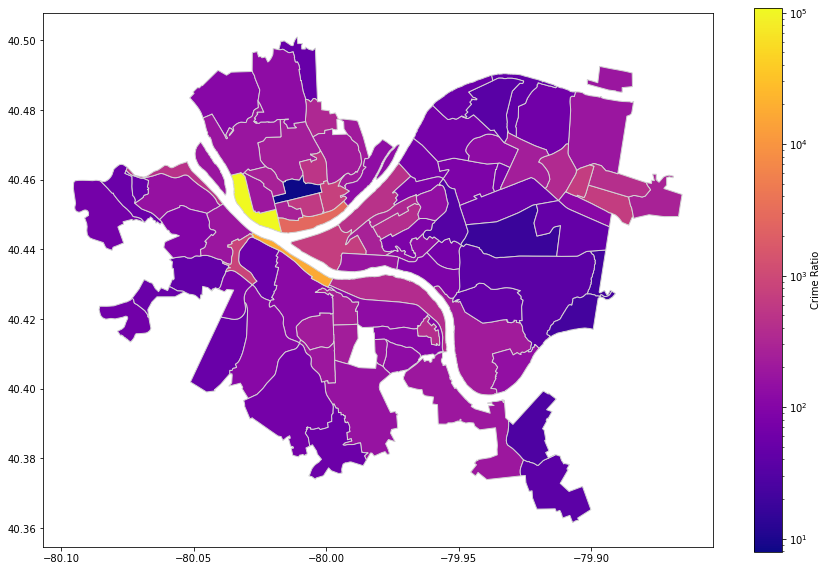

In [43]:
# crs for longitude and latitude
crs = "EPSG:4326"

# read in shape file for neighborhoods
neighborhoods = geopandas.read_file("Neighborhoods/Neighborhoods_.shp")

# convert coordinate system to longitude and latitude
neighborhoods = neighborhoods.to_crs(crs)

# merge the neighborhoods file for the map with crime rate data
crime_map = neighborhoods.merge(arrestAndPop, how = "left", left_on = "hood", 
                                right_on = "Neighborhood") 
#shape file MISSING MOUNT OLIVER BOROUGH MENTION THIS

# display map with my parameters
crime_map.plot(column="Crime_Ratio",
               cmap = "plasma",
               edgecolor = "lightgrey", 
               legend = True,
               legend_kwds = {"label" : "Crime Ratio"}, 
               figsize = (15, 10),
               norm = matplotlib.colors.LogNorm(vmin = crime_map['Crime_Ratio'].min(), vmax = crime_map['Crime_Ratio'].max())
              )

In the chloropleth maps, Chateau, North Shore, and South Shore had crime rates that were so large, it made it difficult to compare neighborhoods with lower crime rates against each other. Therefore, we decided to create another map with the three neighborhoods with the highest crime rates removed in order to obtain a better comparison among the other neighborhoods.

We did this by creating three querey masks for Chateau, North Shore, and South Shore and then combined them using the `&` operator to get the proper subset. After getting the new DataFrame, I can then merge with the neighborhood file and plot again as we did in with the previous map. The only difference is we added the `missing_kwds` parameter.

The second chloropleth map is created in the code cell below:

<AxesSubplot:>

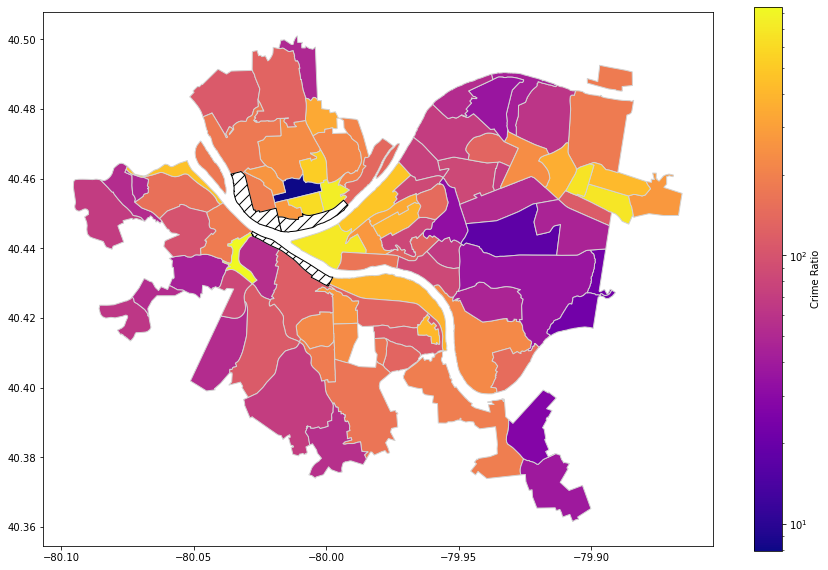

In [44]:
# create query masks for highest neighborhoods
query_mask1 = arrestAndPop["Neighborhood"] != "Chateau"
query_mask2 = arrestAndPop["Neighborhood"] != "South Shore"
query_mask3 = arrestAndPop["Neighborhood"] != "North Shore"

# filter the data. Have to use bitwise operators
lower_values = arrestAndPop[query_mask1 & query_mask2 & query_mask3]

# merge the removed data with the neighborhoods dataframe
lower_crime_map = neighborhoods.merge(lower_values, how = "left", left_on = "hood", right_on = "Neighborhood")

# plot the new data but signify what we removed
lower_crime_map.plot(column = "Crime_Ratio", 
                     cmap = "plasma",
                     edgecolor = "lightgrey",
                     legend = True,
                     legend_kwds = {"label" : "Crime Ratio"},
                     missing_kwds = {
                         "color" : "white",
                         "edgecolor" : "black",
                         "hatch" : "//"},
                     figsize = (15, 10),
                     norm = matplotlib.colors.LogNorm()
                    )

This chloropleth map allows us to better see the difference between the neighborhoods with lower crime rates.

I now wanted to find the top 3 neighborhood with the lowest crime rates. First I had to drop the row with Mount Oliver Borough because as previously mentioned, this is not a part of the city of Pittsburgh.

In [45]:
# 52 is the index of the Mount Oliver Borough 
finalCrime = arrestAndPop.drop([52])

# now list the crime rates
finalCrime.sort_values(by = "Crime_Ratio").head()

,Neighborhood,numOfArrests,Population,Crime_Ratio
18,Central Northside,23,2892.0,7.952974
76,Squirrel Hill North,198,11336.0,17.466478
66,Regent Square,23,1033.0,22.265247
82,Swisshelm Park,30,1345.0,22.304833
55,New Homestead,27,973.0,27.749229


In my dataset, we found that the top 3 neighborhoods with the lowest crime rates are:
1. Central Northside - 7.95
2. Squirrel Hill North - 17.47
3. Regent Square - 22.27

## Metric 2 - Older Housing Data 
---
Another metric that our group thought of was how old are the houses between the neighborhoods. Older housing are found to be unpleasant and also dangerous. In addition, Pittsburgh had issues with water quality, largely due to lead pipes, in 2016. Lead pipes tend to be found in older housing before the effects of lead on the human body were discovered.

In order to get measurable metric, we needed to import a dataset that contains information on proportion of houses built before 1950 based on the Census Tract.

The first step is displayed below:


In [46]:
import geopandas as gpd
#tract is the number of the tract 
#pre1950 represents the percent of homes in each census tract that were built on or before 1950

# create the initial read in file
house_percent_data = pd.read_csv("CSVs/pre1950housing.csv")
#house_percent_data

In [47]:
house_percent_data['TRACT'].dtypes
# rename the Tract column
house_percent_data.rename({'TRACT': 'Census Tracts'}, axis=1, inplace=True)
house_percent_data

,Census Tracts,Pre1950
0,10300,0.658477
1,20100,0.321088
2,20300,0.724907
3,30500,0.324117
4,40200,0.463549
...,...,...
388,980000,0.353982
389,980100,0.000000
390,980700,0.619048
391,981100,0.000000


This dataset is based on Census Tract and not by Neighboorhoods, so we needed another dataset to find out which census tract number corresponds to which Neighboorhood. We have found that for some neighborhoods, multiple Census Tract numbers are referring to that same Neighborhood. So we split the tract numbers into their unique row of Neighborhoods.

In [48]:
#neighborhoods corresponding the tract numbers
#reading in file
tract = pd.read_csv("CSVs/Pittsburgh_Census_Tracts_2010.csv")
#tract.head()
tract['Neighborhood'] = tract['Neighborhood'].astype('string') 
#tract['Neighborhood'].dtypes
tract['Census Tracts'] = tract['Census Tracts'].astype('string')
#tract['Census Tracts'].dtypes
tract['Census Tracts'] = tract['Census Tracts'].str.split(', ')
tract_data = tract.explode('Census Tracts', ignore_index=True)
tract_data['Census Tracts'] = pd.to_numeric(tract_data['Census Tracts'])
tract_data.head()

,Neighborhood,Census Tracts
0,Allegheny Center,562700
1,Allegheny West,562700
2,Allentown,180300
3,Arlington,561600
4,Arlington Heights,561600


We now can merge the two dataframes together to see Neighborhoods with pre1950 built houses percentage data. 

In [49]:
old_house_data=pd.merge(house_percent_data, tract_data, on='Census Tracts')
old_house_data.head()

,Census Tracts,Pre1950,Neighborhood
0,10300,0.658477,Bluff
1,20100,0.321088,Golden Triangle/Civic Arena
2,20300,0.724907,Strip District
3,30500,0.324117,Crawford-Roberts
4,40200,0.463549,Terrace Village


In [50]:
#average Pre1950 percentage for each Neighborhood
percentage_data = pd.DataFrame()
percentage_data=old_house_data.groupby(['Neighborhood', 'Census Tracts'], as_index=False).mean().groupby('Neighborhood')['Pre1950'].mean().reset_index(name="Pre1950")
percentage_data.head()

,Neighborhood,Pre1950
0,Allegheny Center,0.173913
1,Allegheny West,0.173913
2,Allentown,0.658628
3,Arlington,0.759919
4,Arlington Heights,0.759919


<AxesSubplot:>

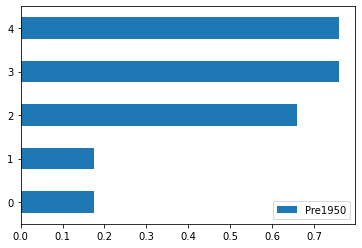

In [51]:
# displays the data
percentage_data.head(5).plot.barh()

Now, we wanted to get a visual representation of the data to identify exactly where the neighborhoods with lower and higher older housing percentage data are located. 



We did this by noting the coordinate reference system for the geographic coordinate system (longitude and latitude) and then reading the neighborhoods shape file from the WPRDC and setting the file to the proper CRS.

In [52]:
# set the filepath and load
fp = "Neighborhoods/Neighborhoods_.shp"
#reading the file stored in variable fp
map_df = gpd.read_file(fp)
# crs for longitude and latitude
crs = "EPSG:4326"

# convert coordinate system to longitude and latitude
map_df = map_df.to_crs(crs)
# check data type so we can see that this is not a normal dataframe, but a GEOdataframe
#map_df.head()
#plotting the map of the shape file preview of the maps without data in it
#map_df.plot()

The first chloropleth map is created below:

<AxesSubplot:>

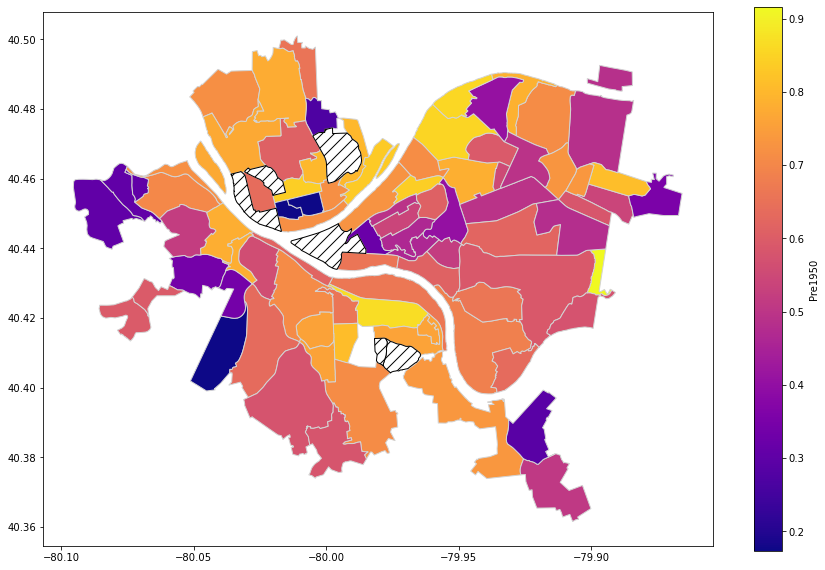

In [53]:
# merge old house percentage rate data with the shape file
old_house_data_map = map_df.merge(percentage_data, how = "left", left_on = "hood", 
                                right_on = "Neighborhood") 

# display map with my parameters
old_house_data_map.plot(column="Pre1950",
               cmap = "plasma",
               edgecolor = "lightgrey", 
               legend = True,
               legend_kwds = {"label" : "Pre1950"},
               missing_kwds = {
                         "color" : "white",
                         "edgecolor" : "black",
                         "hatch" : "//"},
               figsize = (15, 10)
              )

The Pre1950 dataset is missing 5 neighborhoods in its file and we indicated them in white-black color as shown. 
The missing neighborhoods are: 
1. Kirkbridge 
2. Manchester 
3. Downtown
4. Spring Hill 
5. Mt.Oliver

As shown  in the map, Pittsburgh has with many neighborhoods full of wonderful old homes. But we wanted to find top 3 neighborhoods with lowest older housing infrastructure. 


In [54]:
percentage_data.sort_values(by = "Pre1950").head()

,Neighborhood,Pre1950
0,Allegheny Center,0.173913
1,Allegheny West,0.173913
5,Banksville,0.176281
56,Northview Heights,0.270588
53,New Homestead,0.292621


In my dataset, I found that the top 3 neighborhoods with the lowest old houses percentages are:
1. Allegeny Center 
2. Allegheny West 
3. Banksville

## Metric 3 - 
---

## Conclusion
---
In order to make a conclusion about which neighborhood is the best in Pittsburgh, our group had to factor in each metric. All of our metrics have a scale in which the lower the metric, teh better the neighborhood. Therefore, we added all of our metrics and then would compare them. We firstTALK MORE ABOUT THE DATA AND WHAT WE DO WITH IT.

In [55]:
# Combined_Data = finalCrime.merge(old_house_data, how = "left", on = "Neighborhood")

# Combined_Data["Crime_Ratio"] = Combined_Data["Crime_Ratio"] / 1000

# Combined_Data["Final Metric"] = Combined_Data["Crime_Ratio"] + Combined_Data["Pre1950"]
#finalCrime

In [56]:
Combined_Data=finalCrime.merge(percentage_data, how = "left", on='Neighborhood')
Combined_Data["Crime_Ratio"] = Combined_Data["Crime_Ratio"] / 1000

Combined_Data = Combined_Data.drop(columns = ['numOfArrests', 'Population']) # drop non-metric data
Combined_Data = Combined_Data.fillna(0) 
Combined_Data.head(20)

,Neighborhood,Crime_Ratio,Pre1950
0,Allegheny Center,0.612332,0.173913
1,Allegheny West,0.268222,0.173913
2,Allentown,0.269742,0.658628
3,Arlington,0.112851,0.759919
4,Arlington Heights,0.408088,0.759919
5,Banksville,0.052877,0.176281
6,Bedford Dwellings,0.339511,0.494751
7,Beechview,0.112156,0.636752
8,Beltzhoover,0.223854,0.757781
9,Bloomfield,0.083516,0.783336


In [57]:
Combined_Data['Final Metric Sum'] = Combined_Data.sum(axis=1) # sum up the metrics
Combined_Data = Combined_Data.sort_values(by='Final Metric Sum',ascending=True) # sort
Combined_Data[:10]
#IDK ABOUT SUMMING THEM TOGETHER, MAYBE AVG THEM?

,Neighborhood,Crime_Ratio,Pre1950,Final Metric Sum
77,St. Clair,0.133333,0.000000,0.133333
53,Mt. Oliver,0.170569,0.000000,0.170569
74,Spring Hill-City View,0.220277,0.000000,0.220277
5,Banksville,0.052877,0.176281,0.229158
14,California-Kirkbride,0.262765,0.000000,0.262765
54,New Homestead,0.027749,0.292621,0.320370
20,Chartiers City,0.050000,0.305085,0.355085
89,Windgap,0.053455,0.305085,0.358540
31,Fairywood,0.068586,0.305085,0.373671
88,Westwood,0.044671,0.341230,0.385901


# End